In [64]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from scipy.stats import poisson, gamma, expon, binom

from utils import update_prior, mix_dist, normalize_dist, prob_superiority

sns.set_style("whitegrid")

<BarContainer object of 10 artists>

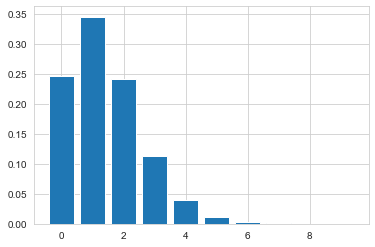

In [3]:
# Average world cap Poisson model scores with lambda = 1.4
lam = 1.4
goals = np.arange(0, 10)
pmf = poisson(lam).pmf(goals)
plt.bar(goals, pmf)

France Avg Lambda = 2.70


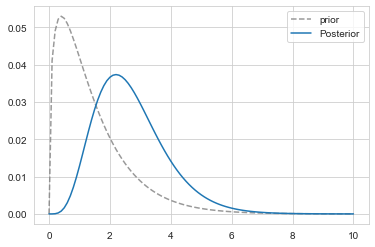

Croatia Avg Lambda = 1.70
P[France > Croatia] = 74.99%


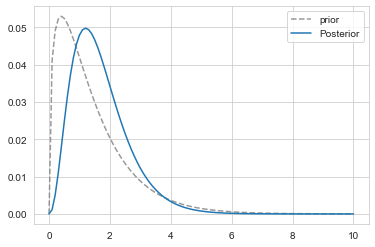

In [4]:
# One game France vs Croatia scored 4:2
# Use the world average score as prior to estimate posterior lambda distribution

lam = 1.4  # world score average = lambda
hypos = np.linspace(0,10,101)
prior = gamma(lam).pdf(hypos)
prior /= prior.sum()

k = 4  # Data, scored 4
likelihood = poisson(mu=hypos).pmf(k)
france =  pd.Series(update_prior(prior, likelihood), index=hypos)
mean = (france.index.values * france.values).sum()

plt.plot(hypos, prior, label='prior', alpha=0.8, linestyle='--', color='gray')
plt.plot(hypos, france, label='Posterior')
plt.legend()
print(f'France Avg Lambda = {mean:.2f}')
plt.show()

k = 2  # Data, scored 4
likelihood = poisson(mu=hypos).pmf(k)
croatia =  pd.Series(update_prior(prior, likelihood), index=hypos)
mean = (croatia.index.values * croatia.values).sum()

plt.plot(hypos, prior, label='prior', alpha=0.8, linestyle='--', color='gray')
plt.plot(hypos, croatia, label='Posterior')
plt.legend()
print(f'Croatia Avg Lambda = {mean:.2f}')

print('P[France > Croatia] = %.2f%%' % (prob_superiority(france, croatia, 'gt')*100))

France score more than Croatia = 56.55% 
France score less than Croatia = 26.34% 
France score tie with Croatia = 16.47%


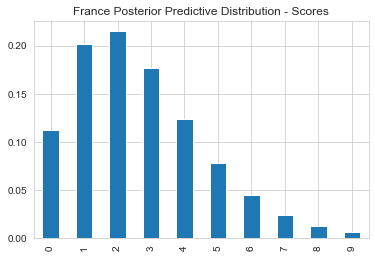

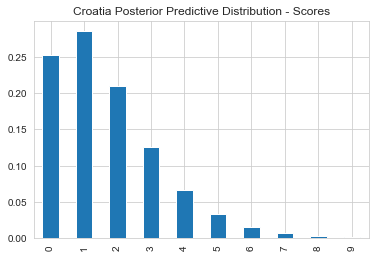

In [5]:
# Arrive on posterior predictive distribution
# P[H|D] = sum of all i( P[Theta_i|D] * P(H|Theta_i, D) )

lam_data_lst = [poisson(lam).pmf(goals) for lam in france.index.values]

france_ppd = mix_dist(*lam_data_lst, ps=france.values)
croatia_ppd = mix_dist(*lam_data_lst, ps=croatia.values)

print(
    'France score more than Croatia = %.2f%%' % (prob_superiority(france_ppd, croatia_ppd, 'gt')*100),
    '\nFrance score less than Croatia = %.2f%%' % (prob_superiority(france_ppd, croatia_ppd, 'lt')*100),
    '\nFrance score tie with Croatia = %.2f%%' % (prob_superiority(france_ppd, croatia_ppd, 'eq')*100),
)

france_ppd.plot(kind='bar')
plt.title('France Posterior Predictive Distribution - Scores')
plt.show()

croatia_ppd.plot(kind='bar')
plt.title('Croatia Posterior Predictive Distribution - Scores')
plt.show()

<ipython-input-13-c416b964eb64>:2: RuntimeWarning: divide by zero encountered in double_scalars
  t_data_lst = [normalize_dist(expon.pdf(ts, scale=1/lam)) for lam in france.index.values]
c:\Users\ztang\OneDrive\Desktop\Workspace\codes\think_bayes\utils.py:6: RuntimeWarning: invalid value encountered in true_divide
  return dist / dist.sum()


P[France score first than Croatia] = 59.05%


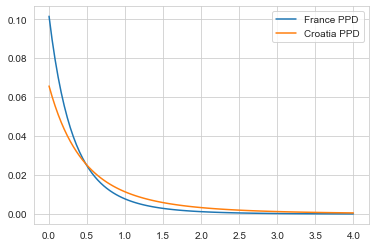

In [13]:
# Posterior Predictive Distribution for Scoring Time
# France before Croatia
ts = np.linspace(0,4,101)
t_data_lst = [normalize_dist(expon.pdf(ts, scale=1/lam)) for lam in france.index.values]

france_ppd = mix_dist(*t_data_lst, ps=france.values)
france_ppd.index = ts
croatia_ppd = mix_dist(*t_data_lst, ps=croatia.values)
croatia_ppd.index = ts

print('P[France score first than Croatia] = %.2f%%' % (prob_superiority(france_ppd, croatia_ppd, 'lt') * 100))

france_ppd.plot(label='France PPD')
croatia_ppd.plot(label='Croatia PPD')
plt.legend()
plt.show()

<ipython-input-114-33af6a23ed15>:9: RuntimeWarning: divide by zero encountered in true_divide
  likelihood *= expon.pdf(d/90, scale=1/lams)


Mean lambda[avg score per game] = 2.70


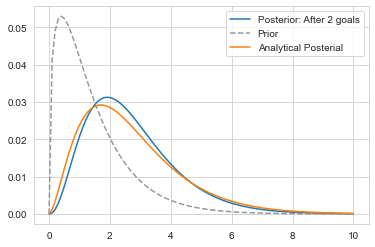

P[score 5 or more after 23 minutes] = 9.39%


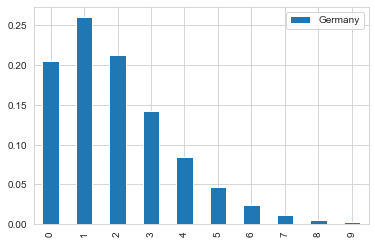

In [114]:
# Germany vs Brazil
# Data 90 minutes game, score at 11min and 23 min
# they also scored 5 more scores after the first two
lams = np.linspace(0, 10, 101)
lam_prior = normalize_dist(pd.Series(gamma(1.4).pdf(lams), index=lams))

likelihood = np.ones(lams.size)
for d in [11, 12]:
    likelihood *= expon.pdf(d/90, scale=1/lams)

lam_posterior = update_prior(lam_prior, likelihood)
mean_lam = (posterior.index.values * posterior.values).sum()

print('Mean lambda[avg score per game] = %.2f' % mean_lam)
plt.plot(posterior, label='Posterior: After 2 goals')
plt.plot(prior, color='gray', linestyle='--', alpha=0.8, label='Prior')
plt.plot(lams, normalize_dist(gamma(mean_lam).pdf(lams)), label='Analytical Posterial')
plt.legend()
plt.show()


# P[score_hat | D] predictive distribution
goals = np.arange(0, 10, 1)
t = (90-23) / 90  # only have 90-23 minutes left
glst = [poisson.pmf(k=goals, mu=lam*t) for lam in lams]
goal_posterior = mix_dist(*glst, ps=lam_posterior.values)

print('P[score 5 or more after 23 minutes] = %.2f%%' % ((1 - goal_posterior.loc[:5-1].sum()) * 100))
goal_posterior.plot(kind='bar', label='Germany')
plt.legend()
plt.show()

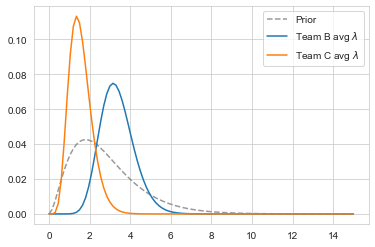

In [44]:
# Hockey Bruins(B) vs Canucks(C)
# Best of seven championship | 0-1, 2-3, 8-1, 4-0, X-X, X-X, X-X
# Data avg score per game per team is around 2.8 follows gamma distribution

lams = np.linspace(0, 15, 101)
prior = pd.Series(normalize_dist(gamma(2.8).pdf(lams)), index=lams)

likelihoodB = np.array([np.prod(poisson.pmf([0,2,8,4], mu=lam)) for lam in lams])
posteriorB = normalize_dist(prior * likelihoodB)

likelihoodC = np.array([np.prod(poisson.pmf([1,3,1,0], mu=lam)) for lam in lams])
posteriorC = normalize_dist(prior * likelihoodC)

prior.plot(label='Prior', color='gray', linestyle='--', alpha=0.8)
posteriorB.plot(label='Team B avg $\lambda$')
posteriorC.plot(label='Team C avg $\lambda$')
plt.legend()

P[B win C] = 70.39%
P[B win Championship] = 78.88%


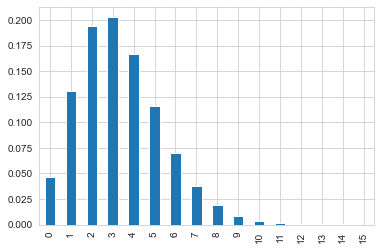

<AxesSubplot:>

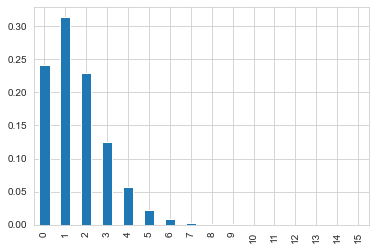

In [70]:
goals = np.arange(0, 16, 1)
goal_data_lst = [poisson.pmf(goals, mu=lam) for lam in lams]

pmfB = mix_dist(*goal_data_lst, ps=posteriorB.values)
pmfC = mix_dist(*goal_data_lst, ps=posteriorC.values)

prob_winB = prob_superiority(pmfB, pmfC, 'gt')
prob_winB_champ = binom.pmf([2, 3], 3, p=prob_winB).sum()

print('P[B win C] = %.2f%%' % (prob_winB * 100))
print('P[B win Championship] = %.2f%%' % (prob_winB_champ * 100))

pmfB.plot(kind='bar')
plt.show()

pmfC.plot(kind='bar')